<img src="https://www1.cbn.com/sites/default/files/styles/video_ratio_16_9/public/media/slider/images/nyu-logo_hdv.jpg?itok=ryqy9DVR" alt="NYU Logo" width="430" height="220"/>

# Introduction to Machine Learning - Final Group Project
Written by Neharika Nair, Well Poolvoraluck, & Ian Ferguson



----------------------
**Goals of this analysis**
* Perform a brief exploratory data analysis on the dataset containing participants' scores on the Hypersensitive Narcissism Scale (HSNS) and the Dirty Dozen Scale to assess the structure and collinearity of the features
* Split the dataset into meaningfully-different groups using PCA and K-Means Clustering
* Perform a regression analysis using elastic-net regression to see the predictive nature of Machiavellianism, Narcissism, and Psychopathy scores of the Dirty Dozen scale on Hypersensitive Narcissism as measured by the HSNS. 

**Methodology** 

With a personality measure, we wanted to compare respondents' relative narcissism with one another - by labelling it with the unsupervised algorithm, the classification via k-means clustering gives a meaningful comparison metric within the participants. 

In addition, because we had the participants' scores on two separate scales, we thought it would be interesting to explore the predictive nature of the Dirty Dozen subscale scores on the HSNS composite scores - to explore the relationship between the different constructs of Machiavellianism, Narcissism, Psychopathy, and Hypersensitive Narcissism.

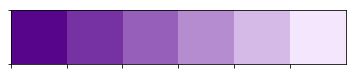

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Custom color palette
goViolets = sns.light_palette("#57068c", reverse=True)
sns.set_palette(goViolets)
sns.palplot(goViolets)

In [2]:
# Read clean dataset from GitHub
url = "https://raw.githubusercontent.com/IanRFerguson/NYU_machineLearning/master/CLEAN_data.csv"

try:
    mlData = pd.read_csv(url)
    print("Success!")
  
except:
    print("Error reading URL ...")

Success!


In [3]:
mlData.head()

,HSNS1,HSNS2,HSNS3,HSNS4,HSNS5,HSNS6,HSNS7,HSNS8,HSNS9,HSNS10,...,DDN3,DDN4,DDM1,DDM2,DDM3,DDM4,age,gender,accuracy,country
0,2,4,5,1,4,5,4,3,3,2,...,1,1,1,2,2,1,37,2,98,PT
1,4,2,2,4,3,4,4,5,4,3,...,2,3,4,4,4,3,34,3,95,PL
2,5,5,5,4,2,5,5,4,4,2,...,4,3,3,4,4,2,22,2,80,AU
3,4,1,2,2,4,5,2,2,5,2,...,4,1,4,2,3,4,24,1,99,US
4,5,3,4,5,5,5,4,5,4,3,...,5,2,4,4,1,5,21,2,90,US


In [4]:
mlData.shape

(53981, 26)

This dataset has > 53,000 observations of 26 variables. Let's move on to the EDA to determine how these variables are interrelated.

## Exploratory Data Analysis (EDA)
------------

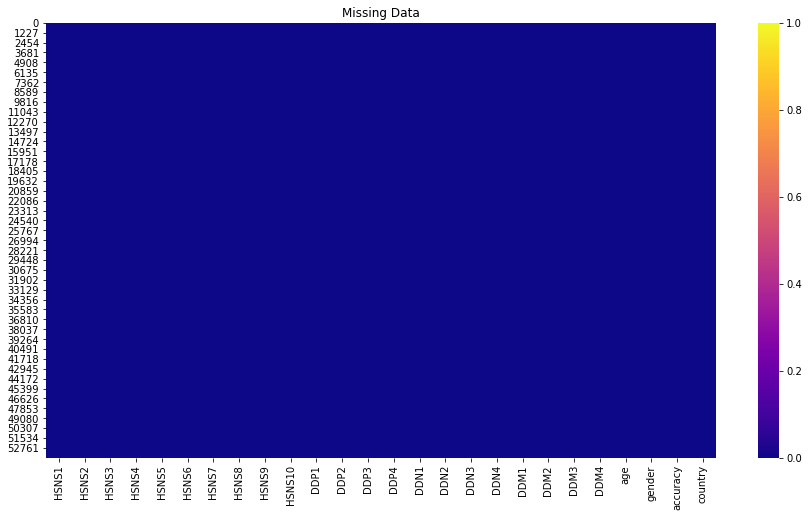

In [5]:
# Visualize missing data
plt.figure(figsize=(15,8))
sns.heatmap(mlData.isnull(), cmap="plasma")
plt.title("Missing Data")
plt.show()

All variables in this dataset are complete - in other words, there is no missing data to account for. We can still make this data easier to work with, however - we'll do so by converting all applicable variables to numeric data types.

In [6]:
# Convert all applicable columns to numeric data type
for var in mlData.columns:
    
    try:
        mlData[var] = pd.to_numeric(mlData[var])
        
    except:
        print("Error at " + var)
        continue

Error at country


Clearly "country" can't be converted to a numeric value, no worries there.
<br> <br>
### Demographics
----------
Let's look at the integrity of the demographic responses - this might tell us something about the participants themselves.

In [7]:
demographics = ["age","gender","accuracy","country"]

# Isolate demographic columns
mlData.loc[:,demographics].sort_values(by="accuracy", ascending=False).head()

,age,gender,accuracy,country
17226,0,3,2147483647,AU
41770,16,1,2147483647,US
5895,17,1,77777777,CA
2491,242523,1,423422,GB
26194,31,3,111111,RS


Yikes! Lots of noisy data here. Let's set some thresholds to filter out data we deem unusable...

* **Accuracy** scores above 100
* **Age** over 100 OR equal to 0
* Gender equal to 0 (which indicates a missed response)

In [8]:
# Create a copy of dataset with * all * observations included
data_allObservations = mlData.copy()

# Drop noisy data
for index, var in enumerate(mlData["country"]):
    
    # Check accuracy
    if mlData["accuracy"][index] > 100:
        
        mlData.drop(index, axis=0, inplace=True)
        
    # Check age
    elif mlData["age"][index] > 100:
        
        mlData.drop(index, axis=0, inplace=True)
        
    elif mlData["age"][index] == 0:
        
        mlData.drop(index, axis=0, inplace=True)
    
    # Missed gender response
    elif mlData["gender"][index] == 0:
        
        mlData.drop(index, axis=0, inplace=True)
        
    else:
        continue

In [9]:
mlData.shape

(52861, 26)

In [10]:
mlData = mlData.reset_index()
mlData.drop("index", axis=1, inplace=True)

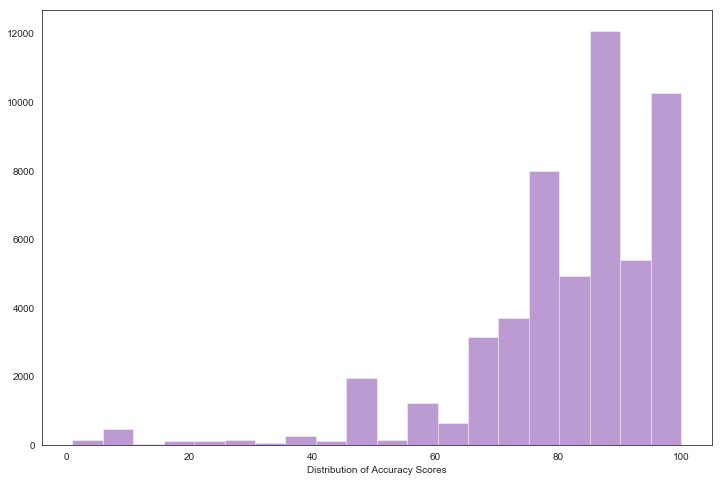

In [11]:
sns.set_style("white")

plt.figure(figsize=(12,8))
sns.distplot(mlData["accuracy"], kde=False, bins=20)
plt.xlabel("Distribution of Accuracy Scores")
plt.show()

In addition to providing their demographic information, participants were instructed to rate how accurate their answers were about themselves on a scale from 0 (random) to 100 (tried their best). The histogram above shows the distribution of these self-rated accuracy scores, with most rating their accuracy within the 75-100 range and few rating theirs at the lower end of the scale.

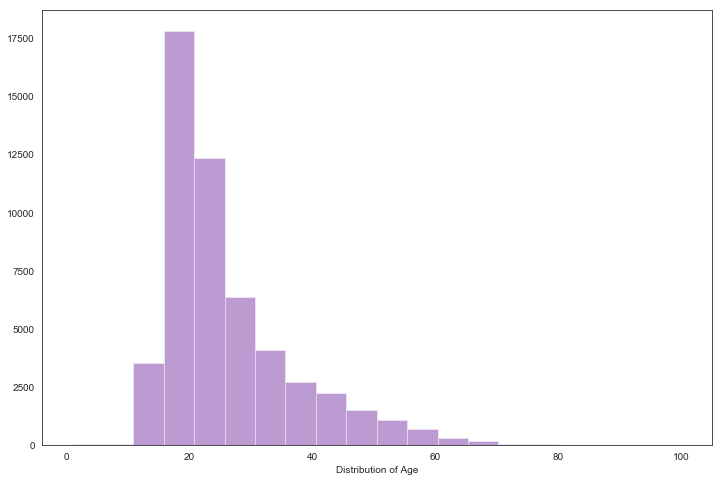

In [12]:
plt.figure(figsize=(12,8))
sns.distplot(mlData["age"], kde=False, bins=20)
plt.xlabel("Distribution of Age")
plt.show()

The preceding histogram shows the age distribution of participants, ranging from late teens to late sixties. Most, by far, fall within the range of 18-23 years of age, resulting in a positively skewed distribution. This was expected given the fact that the personality test was administered online. 



### Intermeasure Relationships
---------

In [13]:
# Custom heatmap function
def machineMap(df, title):
    
    dcor = df.corr()
    
    mask = np.zeros_like(dcor)
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(15,10))
    sns.heatmap(dcor, mask=mask, cmap="plasma", annot=True, linewidths=0.1)
    plt.title(title)
    plt.show()

# Custom histogram function
def machineDist(values, title, bins):
    sns.set_style("white")
    plt.figure(figsize=(15,10))
    sns.distplot(values, bins = bins, kde=False)
    plt.title(title)
    plt.show()

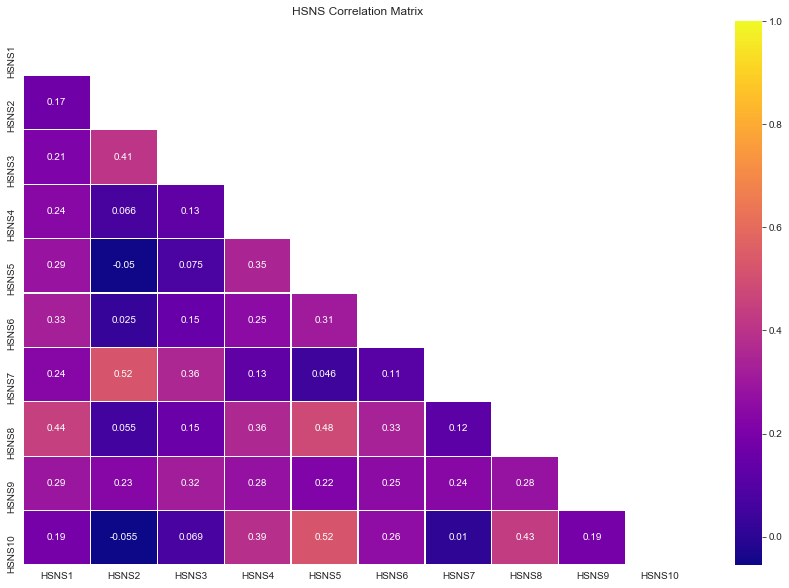

In [14]:
machineMap(mlData.filter(regex="HSNS"), "HSNS Correlation Matrix")

Some relationships worth noting...

* Scores on HSNS2 ("My feelings are easily hurt by ridicule or the slighting remarks of others") are highly corrleated to HSNS7 scores ("I often interpret the remarks of others in a personal way") <br> <br>
* Scores on HSNS5 ("I feel that I have enough on my hands without worrying about other people's troubles") correlated positively with scores on HSNS8 ("I easily become wrapped up in my own interests and forget the existence of others") and HSNS10 ("I am secretly "put out" or annoyed when other people come to me with their troubles, asking me for my time and sympathy
") <br> <br>

In both cases, these sets of questions seem to be assessing the same personality covariates in slightly different ways; therefore, these large intermeasure correlations are somewhat intuitive.

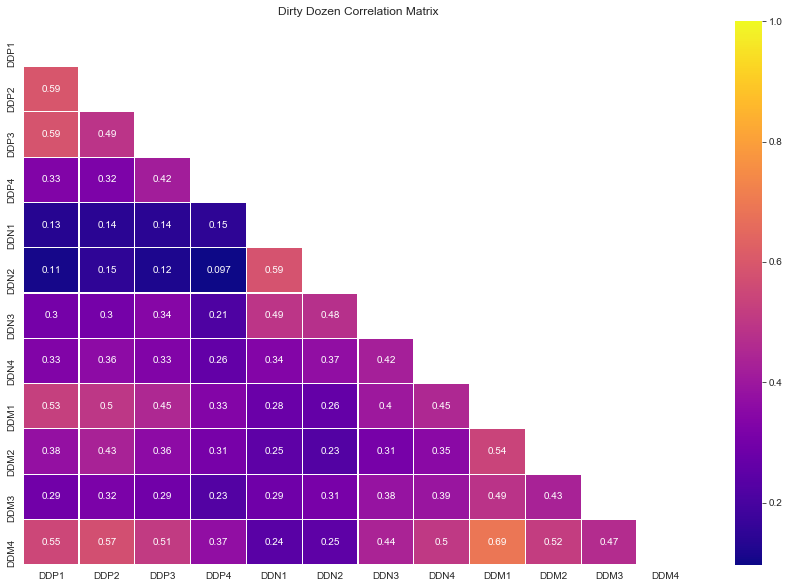

In [15]:
machineMap(mlData.filter(regex="DD"), "Dirty Dozen Correlation Matrix")

These submeasures assess three distinct components of personality - Psychopathy (DDP), Narcissism (DDN), and Machiavellianism (DDM). We observe high inter-item correlations for each subscale, but not between subscales. <br> <br>

Psychopathy measures appear to be *slightly more* intercorrelated with Machiavellianism scores than Narcissism scores.

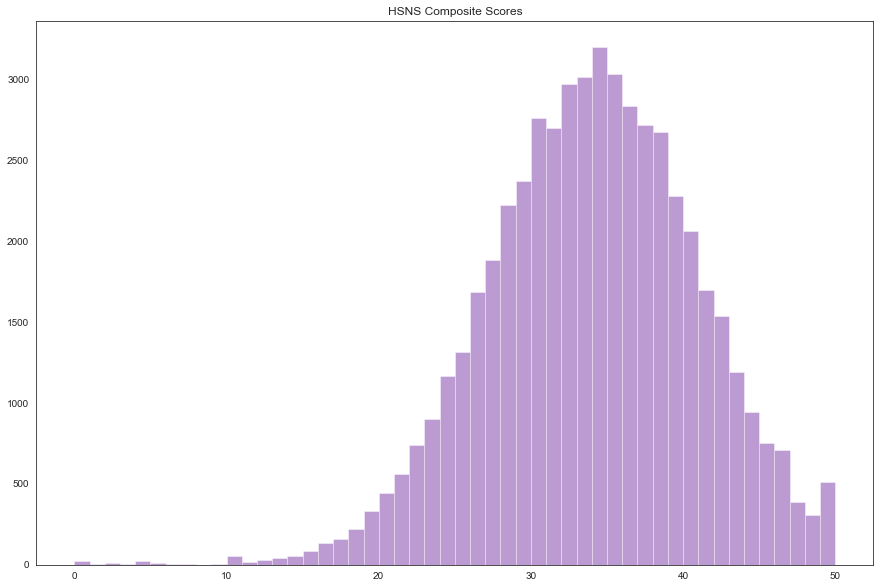

In [16]:
# HSNS Distribution of Composite Scores
machineDist(mlData.filter(regex="HSNS").sum(axis=1), "HSNS Composite Scores", 50)

The histogram above shows the distribution of HSNS composite scores, which appears slightly skewed left with no outliers on either end. The vast majority scored within the 30-40 range, and very few who scored below 20. Notably, there is also a relatively sharp rise in the number of participants who obtained the maximum HSNS composite score of 50. 

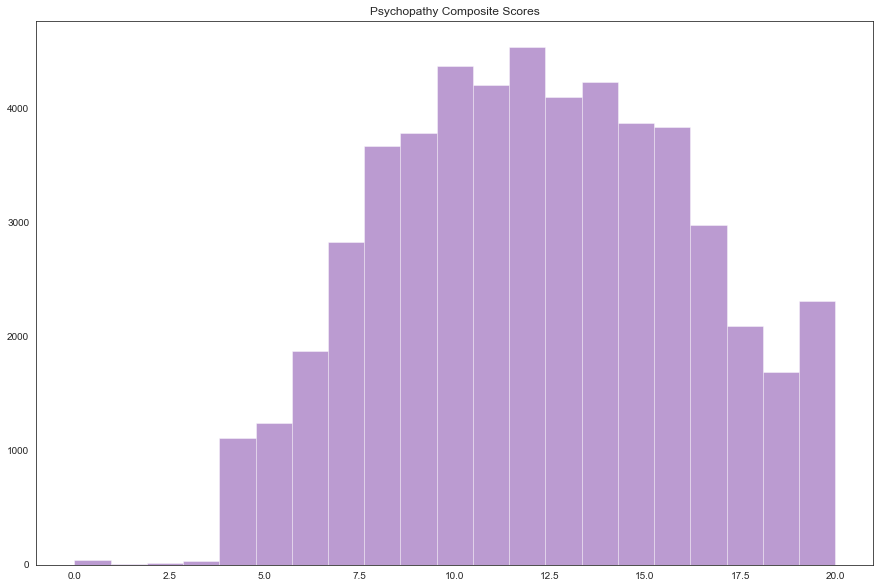

In [17]:
machineDist(mlData.filter(regex="DDP").sum(axis=1), "Psychopathy Composite Scores", 21)

The distribution of Psychopathy composite scores (DDP; from the Dirty Dozen Scale)appears slightly skewed left, with most scoring in the 8-16 range and very few at the low end of the scale (0-4). Interestingly, there also seems to be a small but relatively pronounced peak at the upper edge of the distribution. 

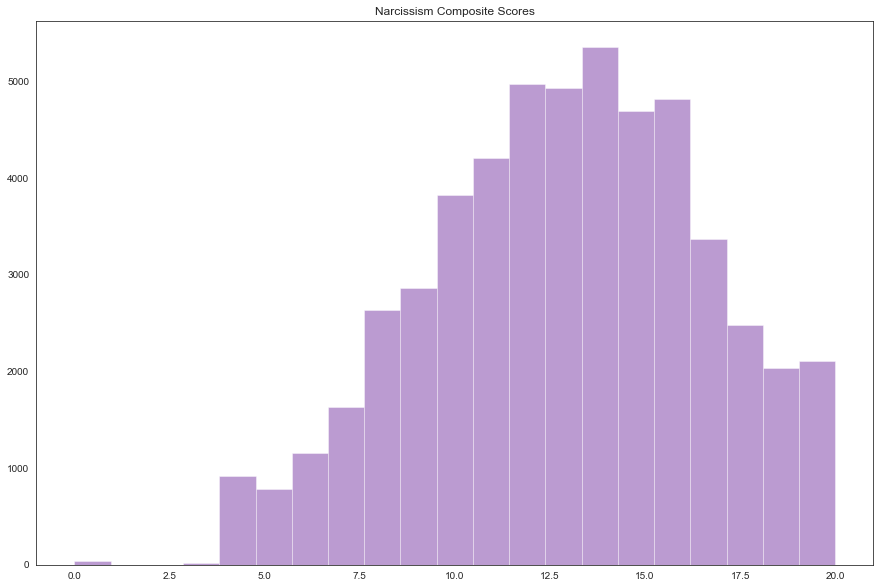

In [18]:
machineDist(mlData.filter(regex="DDN").sum(axis=1), "Narcissism Composite Scores", 21)

The distribution of Narcissism composite scores (DDN; from the Dirty Dozen Scale) appears to be slightly more skewed left compared to that of psychopathy composite scores above. The peak is also not as broad, with most data concentrated in the 12-16 score range and again with very few scoring in the 0-4 range. 

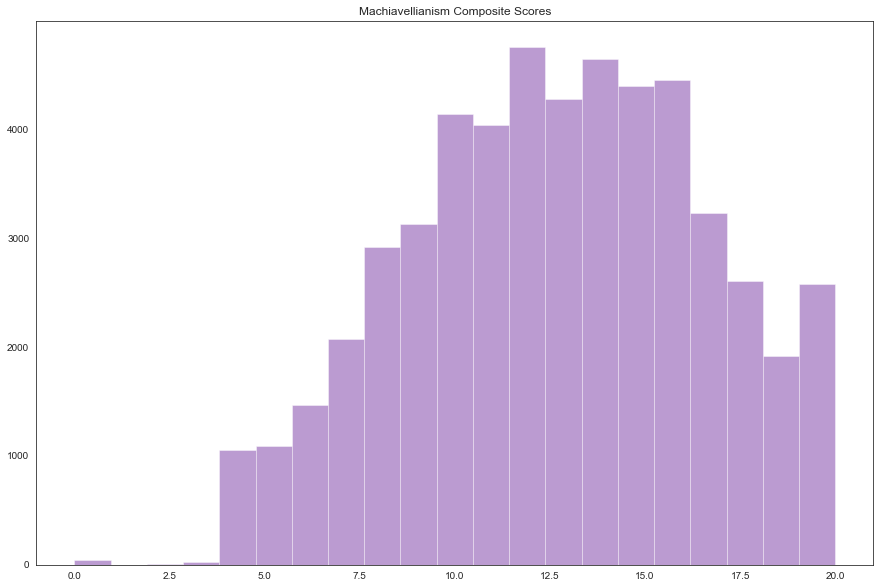

In [19]:
machineDist(mlData.filter(regex="DDM").sum(axis=1), "Machiavellianism Composite Scores", 21)

Similarly, the distribution of Machiavellianism composite scores (DDM; from the Dirty Dozen Scale) looks slightly skewed left, with most scoring between 10 and 16 and very few scoring below 5. Additionally, like the Psychopathy composit scores, there seems to be a small but relatively pronounced peak at the upper edge of this distribution as well. This peak seen in both the Psychopathy and Machiavellianism scores (from the Dirty Dozen Scale) may be explained by the slight correlation between the measures seen earlier in the analysis.

### Geographic Dummy Variables
--------------------
Before we proceed to the model construction, let's transform our only categorical variable (country) to a series of binary dummy variables. This will allow us to maximize the granularity of this feature in particular.

In [20]:
# Copy df without country variable
mlData_noGeo = mlData.copy()
mlData_noGeo.drop("country", axis=1, inplace=True)

# Get count of unique countries in dataset
mlData["country"].nunique()

168

In [21]:
# Create one column per factor level ... +168 columns
country_dummies = pd.get_dummies(mlData["country"], drop_first=True)

# Wide df will have 192 columns
mlData_wide = pd.concat([mlData, country_dummies], axis=1)
mlData_wide.drop("country", axis=1, inplace=True)

mlData_wide.head()

,HSNS1,HSNS2,HSNS3,HSNS4,HSNS5,HSNS6,HSNS7,HSNS8,HSNS9,HSNS10,...,UY,UZ,VE,VG,VN,WS,YT,ZA,ZM,ZW
0,2,4,5,1,4,5,4,3,3,2,...,0,0,0,0,0,0,0,0,0,0
1,4,2,2,4,3,4,4,5,4,3,...,0,0,0,0,0,0,0,0,0,0
2,5,5,5,4,2,5,5,4,4,2,...,0,0,0,0,0,0,0,0,0,0
3,4,1,2,2,4,5,2,2,5,2,...,0,0,0,0,0,0,0,0,0,0
4,5,3,4,5,5,5,4,5,4,3,...,0,0,0,0,0,0,0,0,0,0


## Principal Component Analysis (PCA) + K-Means Clustering
---------------
With the geographic dummy variables included, this dataset has 192 unique features. The high dimensionality of this data makes accurately clustering it (let alone visualizing it) very difficult. We will take some steps to solve this problem.

* First, we'll reduce the dimensionality of this data from **192 features** to **2 features** using PCA
* We'll then measure the amount of variance accounted for by each component
* Next, we'll apply a K-Means Clustering algorithm to the dataset to provide categorical group labels
* We'll then compare several clustering options to find the *k* value that provides maximal centroid separation
* Finally, we'll project our results to the high dimensional dataset to assess the functional outcomes of group membership (i.e., *how and why* these groups are truly different!

### Accounting for Geography
----------------
As a first pass, we'll include all geographic features (i.e., all 192 variables)

In [22]:
# ML Imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances

sns.set_style("white")

In [23]:
# Standardize all variables to account for feature variance
scaler = StandardScaler()
scaler.fit(mlData_wide)
mlData_scaled = scaler.transform(mlData_wide)

In [24]:
# Use PCA to reduce feature interactions to 2-dimensional space
pca = PCA(n_components=2, random_state=823)
pca.fit(mlData_scaled)
mld_reduced = pca.transform(mlData_scaled)

mld_reduced.shape

(52861, 2)

In [25]:
# How do these components explain feature variance in the data?
print("Component #1: \t\t" + str(pca.explained_variance_[0]))
print("Component #2: \t\t" + str(pca.explained_variance_[1]))
print("Total Variance:\t\t" + str(pca.explained_variance_[0] + pca.explained_variance_[1]))

Component #1: 		7.087946552605385
Component #2: 		2.601475355619236
Total Variance:		9.68942190822462


This reduction in dimension accounts for approximately 9.7% of the variance in the present dataset. 

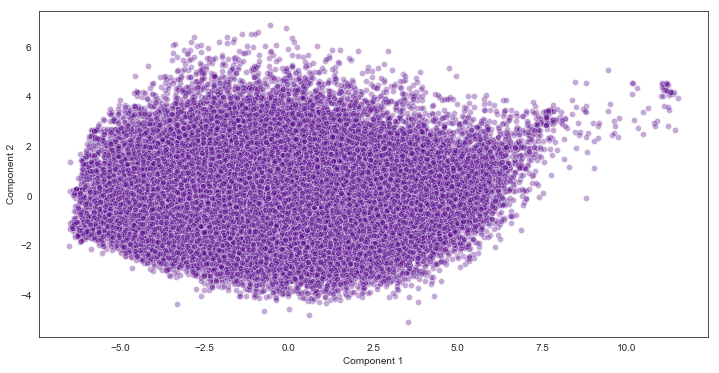

In [26]:
# Plot low dimensional data
plt.figure(figsize=(12,6))
sns.scatterplot(x=mld_reduced[:,0], y=mld_reduced[:,1], alpha=0.35)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [27]:
# Let's loop through k options to determine the optimal number of clusters
kVars = range(1,20)
sum_of_squares = []

for k in kVars:
    
    temp = KMeans(n_clusters = k)
    temp.fit(mld_reduced)
    sum_of_squares.append(temp.inertia_)

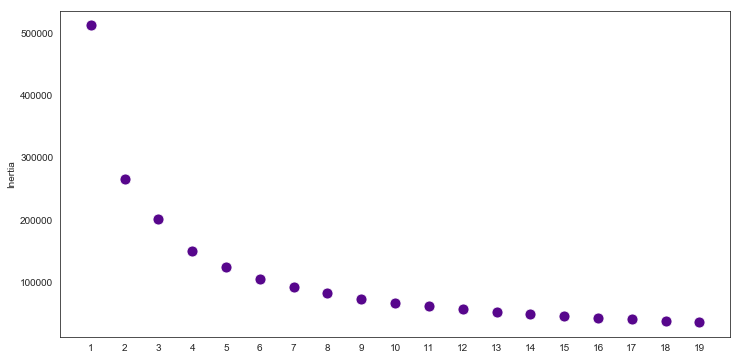

In [28]:
# We'll select k using the Elbow Method
plt.figure(figsize=(12,6))
sns.scatterplot(x = kVars, y = sum_of_squares, s=120)
plt.xticks(kVars)
plt.ylabel("Inertia")
plt.show()

Going by the elbow method - we could cluster that data into 4, 5, 6, or 7 groups.

Since the number 6 falls right in the middle of the curve - we will look at clustering the data into 6 groups first, and then evaluate the model. 

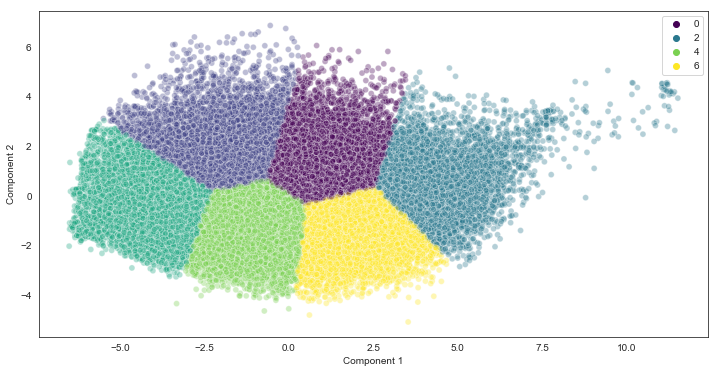

In [29]:
# Cluster data into 6 groups
km = KMeans(n_clusters=6)
km.fit(mld_reduced)

# Cluster data with the trained K Means algorithm
groups = km.predict(mld_reduced)

# Plot low dimensional data with clusters
plt.figure(figsize=(12,6))
sns.scatterplot(x = mld_reduced[:, 0], y = mld_reduced[:, 1], 
                hue = km.labels_, palette = "viridis", alpha = 0.35)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Evaluating Clustering
### Silhouette Coeffecient
-------------------
Next, we wanted to evaluate the performance of the clustering algorithm using the Silhouette Coefficient. The grand Silhouette Coefficient refers to the mean silhouette coefficient of each individual score - which, in turn, is comprised of two scores - the mean distance between a sample and all other points in the same class, and the mean distance between a sample and all other points in the next nearest cluster.

A higher Silhouette Coefficient relates to a model with better defined clusters. Silhouette Coefficients range from: 

* -1 (incorrect clustering) to 
* +1 (highly dense clustering) 
* Scores around 0 indicate overlapping clusters


We next wanted to try other k values to determine the most optimal number of clusters for our analysis by comparing the Silhouette Coefficient scores for each number of clusters. The highest Silhouette Coefficient scores will be related to the model with best defined clusters. 

Using *k-values* 3 through 8, we'll fit a series of models and assess the Silhoutte Coefficient for each fitted model. We can use the results of this procedure to select the optimal number of clusters.

In [30]:
k_options = [3,4,5,6,7,8]
sil_score = []

print("# of Clusters \t\t Silhoutte Score")

# Loop through k values, fit model, assess Silhoutte Score
for ko in k_options:

    temp = KMeans(n_clusters = ko)
    temp.fit(mld_reduced)

    labels = temp.labels_
    val = metrics.silhouette_score(mld_reduced, labels)
    sil_score.append(val)

    print(str(ko) + " Clusters \t\t" + str(val))

# of Clusters 		 Silhoutte Score
3 Clusters 		0.32163680719577764
4 Clusters 		0.3526781848185391
5 Clusters 		0.32946930436872235
6 Clusters 		0.33473023737787816
7 Clusters 		0.3195334586455201
8 Clusters 		0.32121052924004384


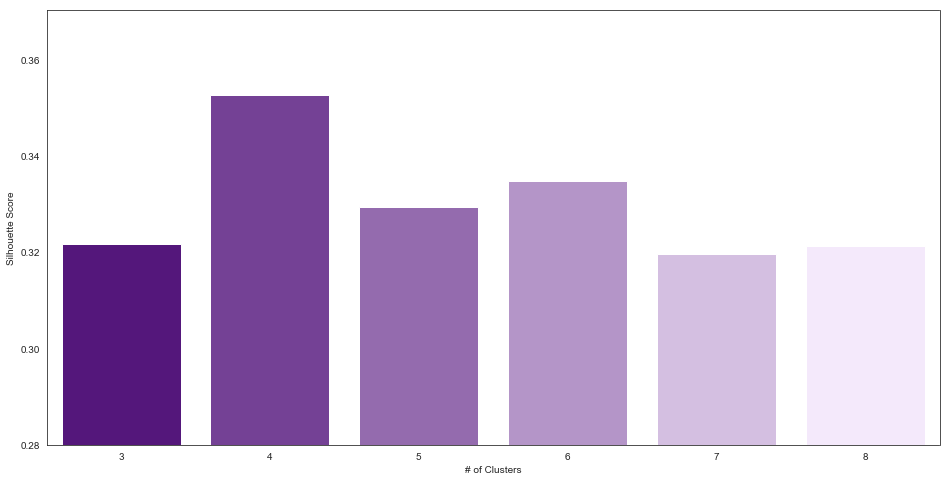

In [31]:
# Plot Silhoutte Coefficients for k values
plt.figure(figsize=(16,8))
sns.barplot(x = k_options, y = sil_score, palette=goViolets)
plt.ylim(bottom = 0.28)
plt.xlabel("# of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

Clearly, **4 clusters** appears to produce a model with the highest Silhoutte Coefficient, and therefore the maximal separation. With this in mind, we'll fit another K-Means Clustering algorithm to maximally separate the data.

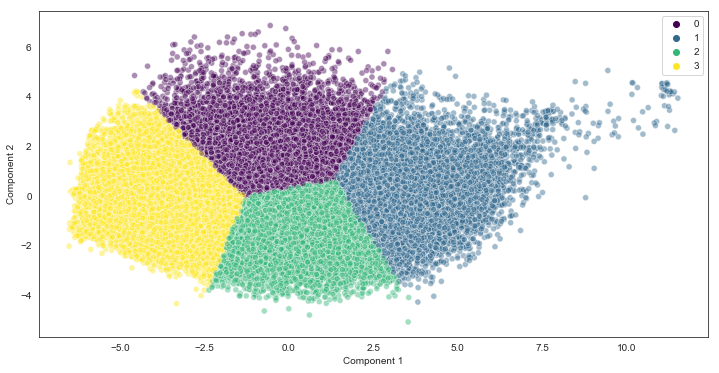

In [32]:
# Fit updated model
km4 = KMeans(n_clusters=4)
km4.fit(mld_reduced)

# Plot updated results
sns.set_style("white")
plt.figure(figsize=(12,6))
sns.scatterplot(x = mld_reduced[:, 0], y = mld_reduced[:, 1], 
                hue = km4.labels_, palette="viridis", alpha = 0.45)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

###Calinski-Harabasz Index (Variance Ratio Criterion)
----------
Following the k-value selection procedure, we'll apply the Calinski-Harabasz Index to this algorithm as another means of evaluation.

* The index is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)

* A higher Calinski-Harabasz score relates to a model with better defined clusters.

In [33]:
k_options = [3,4,5,6,7,8]
calinskis_score  =  []

print("# of Clusters \t\t Calinski Score")

# Loop through k options, evaluate C-H Index
for ko in k_options:

    temp = KMeans(n_clusters = ko)
    temp.fit(mld_reduced)

    labels = temp.labels_
    val = metrics.calinski_harabaz_score(mld_reduced, labels)
    calinskis_score.append(val)

    print(str(ko) + " Clusters \t\t" + str(val))

# of Clusters 		 Calinski Score
3 Clusters 		40425.245115734
4 Clusters 		42487.73516436807
5 Clusters 		41067.5673093855
6 Clusters 		40744.27646266813
7 Clusters 		39476.28071384169
8 Clusters 		38959.234278610056


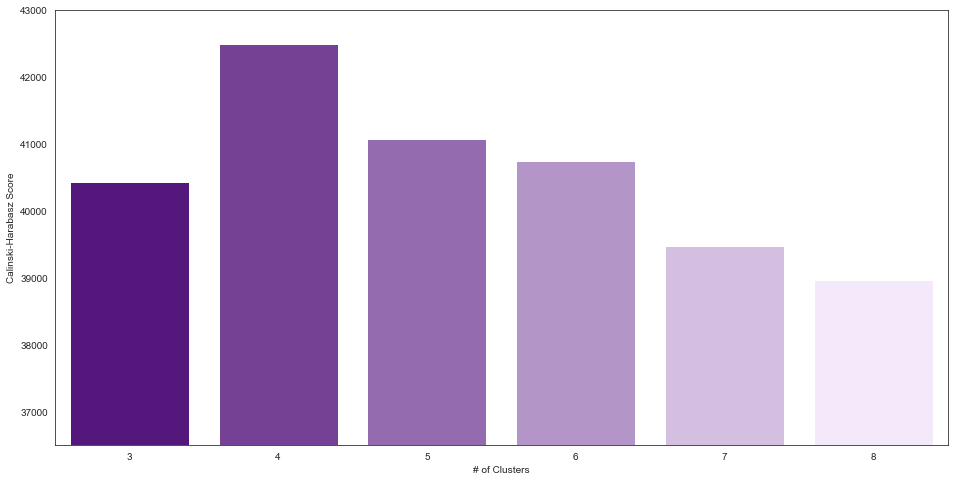

In [34]:
# Plot results
plt.figure(figsize=(16,8))
sns.barplot(x = k_options, y = calinskis_score, palette=goViolets)
plt.ylim(bottom = 36500)
plt.ylim(top = 43000)
plt.xlabel("# of Clusters")
plt.ylabel("Calinski-Harabasz Score")
plt.show()

This lends support to our selection of *k*=4 in the clustering algorithm - it's evident that four clusters provides the highest Calinski-Harabasz score, which suggests that this selection provides the most well-defined clusters.

### Davies-Bouldin Index
-------------
Lastly, we'll evaluate the Davies-Bouldin score for each possible k value.

* This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

* Zero is the lowest possible score. Values closer to zero indicate a better partition.

In [35]:
k_options = [3,4,5,6,7,8]
davies_score  =  []

print("# of Clusters \t\t Davies Bouldin Score")

# Loop through k options, evaluate D-B score
for ko in k_options:

    temp = KMeans(n_clusters = ko)
    temp.fit(mld_reduced)

    labels = temp.labels_
    val = metrics.davies_bouldin_score(mld_reduced, labels)
    davies_score.append(val)

    print(str(ko) + " Clusters \t\t" + str(val))

# of Clusters 		 Davies Bouldin Score
3 Clusters 		1.0296445716184552
4 Clusters 		0.8837838500310893
5 Clusters 		0.9159640401419857
6 Clusters 		0.8477237260508961
7 Clusters 		0.8952541377143988
8 Clusters 		0.8808023332047719


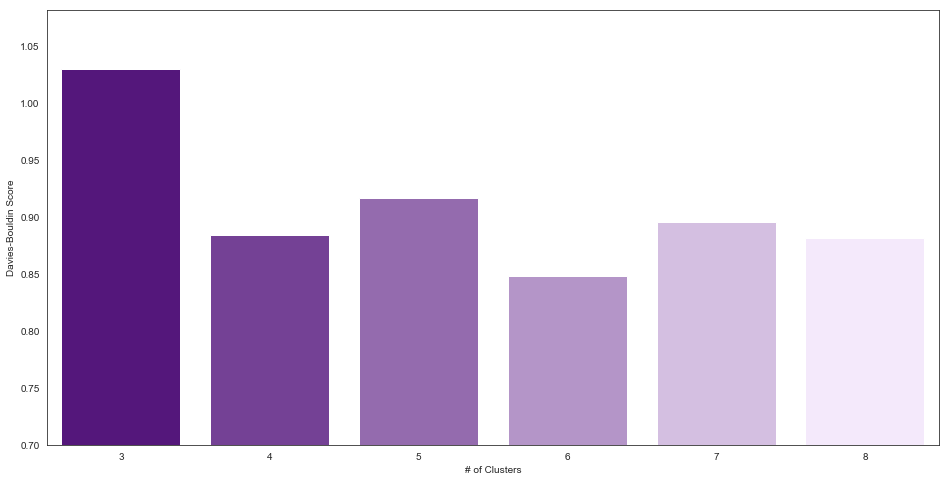

In [36]:
# Plot results
plt.figure(figsize=(16,8))
sns.barplot(x = k_options, y = davies_score, palette=goViolets)
plt.ylim(bottom = 0.7)
plt.xlabel("# of Clusters")
plt.ylabel("Davies-Bouldin Score")
plt.show()

Notably, **6 Clusters** provides the lowest Davies-Bouldin score, with **4 Clusters** scoring slightly more. 

Considering the optimal scores that our 4 Cluster algorithm provided via other metrics, we maintain that this is our best option to provide maximal group separation in the present data.

### Discounting Geography
-------------------------
Given the high number of geographic features, it may be theoretically interesting to drive at the same results without including participants' country of origin. We'll follow the same process as we did above, without the dummy variables included for country.

In [37]:
# Standardize all variables to account for feature variance
scaler = StandardScaler()
scaler.fit(mlData_noGeo)
noGeo_scaled = scaler.transform(mlData_noGeo)

# Use PCA to reduce feature interactions to 2-dimensional space
pca_g = PCA(n_components=2, random_state=823)
pca_g.fit(noGeo_scaled)
noGeo_reduced = pca_g.transform(noGeo_scaled)

noGeo_reduced.shape

(52861, 2)

In [38]:
# How do these components explain feature variance in the data?
print("Component #1: \t\t" + str(pca_g.explained_variance_[0]))
print("Component #2: \t\t" + str(pca_g.explained_variance_[1]))
print("Total Variance:\t\t" + str(pca_g.explained_variance_[0] + pca_g.explained_variance_[1]))

Component #1: 		7.0791985162358015
Component #2: 		2.5891591559505653
Total Variance:		9.668357672186367


In this case, feature decomposition doesn't explain a significantly different amount of variance than the PCA performed earlier (~9.7% in this case as well).

Next, let's loop through several possible k values (*k* = Number of clusters); using each model's silhoutte score, we'll select the number of clusters that provide maximal separation. 

In [39]:
k_options = [3,4,5,6,7,8]

print("# of Clusters \t\t Silhoutte Score")
for ko in k_options:

    # Fit temporary model
    temp = KMeans(n_clusters = ko)
    temp.fit(noGeo_reduced)

    # Obtain silhouette coefficient
    labels = temp.labels_
    val = metrics.silhouette_score(noGeo_reduced, labels)

    print(str(ko) + " Clusters \t\t" + str(val))

# of Clusters 		 Silhoutte Score
3 Clusters 		0.32189743330198944
4 Clusters 		0.3521540669248048
5 Clusters 		0.3294614876434796
6 Clusters 		0.33491554053638817
7 Clusters 		0.3197645108440313
8 Clusters 		0.3216646928540068


Much like the dataset with geographic information included, it's evident that **four clusters** provides the maximal separation of these data points. It's worth noting that the Silhoutte Coefficient for this latter approach is slightly higher (0.3532) than the value obtained with geographic information included (0.3524); this suggests that removing geographic information provides clusters that are slightly more distinct.

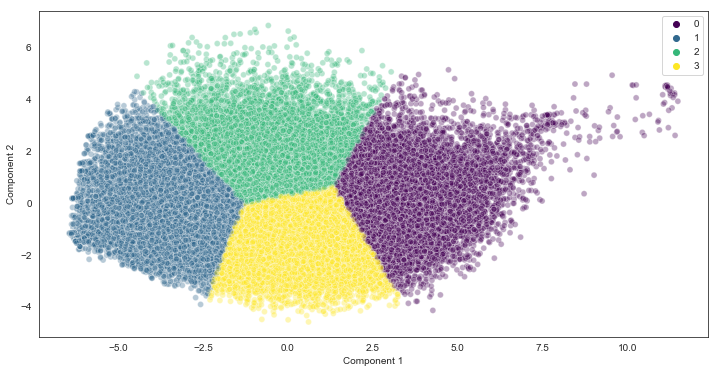

In [40]:
# Fit model
kmg = KMeans(n_clusters=4)
kmg.fit(noGeo_reduced)

# Plot results
plt.figure(figsize=(12,6))
sns.scatterplot(x=noGeo_reduced[:,0], y=noGeo_reduced[:,1],
                hue=kmg.labels_, palette="viridis", alpha=0.35)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

### Outcomes of Clustering
-------------------
Lastly, let's take what we learned about this data and apply it to the high dimensional dataset. This will allow us to assess feature variance across different clusters, which is a meaningful and neccesary step in this analysis!

In [41]:
# Push to high dimensional space
mlData["CLUSTER"] = km4.predict(mld_reduced)
clustered_data = mlData.copy()

# Isolate columns
hsns_vars = list((clustered_data.filter(regex="HSNS")).columns)
ddp = list((clustered_data.filter(regex="DDP")).columns)
ddn = list((clustered_data.filter(regex="DDN")).columns)
ddm = list((clustered_data.filter(regex="DDM")).columns)

# Calculate row sums
clustered_data["HSNS_sum"] = clustered_data[hsns_vars].sum(axis=1)
clustered_data["DDP_sum"] = clustered_data[ddp].sum(axis=1)
clustered_data["DDN_sum"] = clustered_data[ddn].sum(axis=1)
clustered_data["DDM_sum"] = clustered_data[ddm].sum(axis=1)

# Drop subscale scores
badVars = (hsns_vars + ddp + ddn + ddm)
clustered_data.drop(badVars, axis=1, inplace=True)

clustered_data.groupby("CLUSTER").mean()

,age,gender,accuracy,HSNS_sum,DDP_sum,DDN_sum,DDM_sum
CLUSTER,,,,,,,
0,24.710082,1.223951,83.969772,31.320235,14.727063,11.483642,13.976174
1,30.153896,1.532276,84.126207,26.093770,7.969253,9.386510,8.341355
2,25.007235,1.476334,80.108338,35.016861,10.671183,13.802514,12.038197
3,23.730491,1.282475,86.840981,40.452287,16.294433,16.738023,16.941533


Here we see the functional outcomes of our clustering at a high dimensional level. Gender appears to be fairly static across the clusters, which suggests that men and women weren't prone to being clustered in one group more so than another. Accuracy is similarly homogenous across clusters. <br> <br>

In terms of cluster differences we observe the following:

* Cluster 1 respondents were the youngest on average and also reported the highest HSNS and DD scores
* Conversely, Cluster 3 respondents were the oldest on average and yielded the lowest scores on average
* Cluster 1 respondents also yielded the highest mean accuracy scores; since these values were self-reported, it's possible that self-reported accuracy was driven by high trait narcissism.

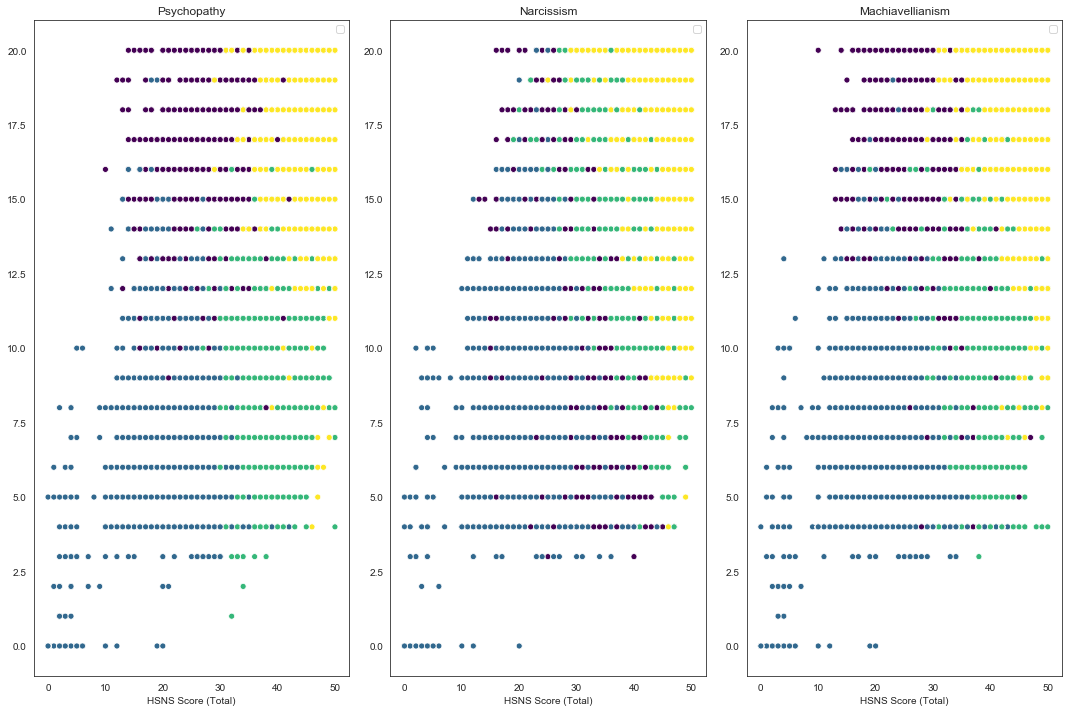

In [42]:
# Custom scatterplot function
def machineScatter(Y, title):

    sns.scatterplot(data=clustered_data, x="HSNS_sum", y = Y, hue="CLUSTER", palette="viridis")
    plt.xlabel("HSNS Score (Total)")
    plt.ylabel("")
    plt.title(title)
    plt.legend("")

# Plot scores for each Dark Triad submeasure vs. HSNS score
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
machineScatter("DDP_sum", "Psychopathy")

plt.subplot(1,3,2)
machineScatter("DDN_sum", "Narcissism")

plt.subplot(1,3,3)
machineScatter("DDM_sum", "Machiavellianism")

plt.tight_layout()
plt.show()

While Psychopathy and Machiavellianism scores appear to be generally well separated, it seems as though our clustering algorithm failed to separate participants based on their Narcissism scores. This could be due to low predictive power offered by the Narcissism measures, or else due to the lack of inter-item correlations assessed earlier in this analysis.

-------------------------
## Elastic Net Regression
--------------------------
Underlying theory - The Dirty Dozen is a psychological test that measures the dark triad of personality constructs: <br> 
* Machiavellianism (the manipulative personality trait)
* Narcissism (including facets from the clinical disorder such as grandiosity, entitlement, dominance, and superiority) 
* Psychopathy (subclinically characterized by high impulsivity and low empathy). <br> <br>

The HSNS, on the other hand, measures a construct known as vulnerable narcissism (characterized by hypersensitivity, entitlement and vulnerability). Previous research already shows the HSNS scores to have moderate correlations with the Narcissism sub-scale of the Dirty Dozen measure (Maples et al., 2014). Going by the established relationship between these constructs, we wanted to see how much a person's score for the Machiavellianism, Narcissism, and Psychopathy sub-scales of the Dirty Dozen Measure would predict their Hypersensitive Narcissism scores. <br> <br>

* First, we'll sum participants' scores on HSNS and on the Psychopathy, Narcissism, and Machiavellianism subscales of the Dirty Dozen Scale respectively
* In our first model we'll regress on HSNS scores using summed scores of the Dirty Dozen subscales
* We'll then train a second model using each individual Dirty Dozen item as a regressor


In [43]:
# New instance variable for data to use in elastic net
netData = mlData.copy()
netData.drop(["age", "gender", "accuracy", "country"], axis=1, inplace=True)

# Isolate columns
target_cols = list((netData.filter(regex="HSNS")).columns)
ddp = list((netData.filter(regex="DDP")).columns)
ddn = list((netData.filter(regex="DDN")).columns)
ddm = list((netData.filter(regex="DDM")).columns)

# Caluclate row sums of subscales
netData["HSNS_sum"] = netData[target_cols].sum(axis=1)
nd_wide = netData.copy()

netData["DDP_sum"] = netData[ddp].sum(axis=1)
netData["DDN_sum"] = netData[ddn].sum(axis=1)
netData["DDM_sum"] = netData[ddm].sum(axis=1)

# Drop individual HSNS measures (We're only interested in the sum)
toDrop = []

for k in netData.columns:

    if "sum" not in k:
        toDrop.append(k)

    else:
        continue

# Remove redundant columns from data set
netData.drop(toDrop, axis=1, inplace=True)

# Dimensions of reduced data set
netData.shape

(52861, 4)

Using this concise representation of the data, we'll train an elastic net regression model to predict HSNS scores. First, we have to select an appropriate *alpha* value, which serves as a penalty term in the model.

In [44]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Select X and y values from dataset (i.e., IVs and DVs)
X = netData.filter(regex="DD")
y = netData.filter(regex="HSNS")

# Split dataset into train and test segments
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 823)

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1.0]
r2 = []
print("Alpha \t\t R^2 \t\t\t\t RMSE")
for a in alphas:

    # Fit model with iterative alpha value + report R^2 and Root Mean Square Error (RMSE)
    temp = ElasticNet(alpha=a).fit(X, y)
    temp_score = temp.score(X, y)
    r2.append(temp_score)
    temp_yPred = temp.predict(X)
    mse = mean_squared_error(y, temp_yPred)
    print(str(a) + "\t\t" + str(temp_score) + "\t\t" + str(np.sqrt(mse)))

Alpha 		 R^2 				 RMSE
0.0001		0.3902314294728977		5.37333770214779
0.001		0.39023142890039586		5.37333770467026
0.01		0.39023130900550185		5.3733382329327455
0.1		0.3902185457691443		5.373394468049471
0.3		0.39011645740276435		5.3738442505916675
0.5		0.3899160132772945		5.3747272609913095
0.7		0.38962103956666827		5.376026435932962
1.0		0.3890095499294747		5.378718666283672


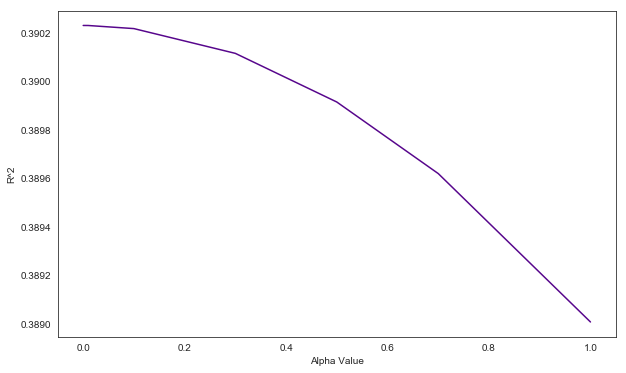

In [45]:
plt.figure(figsize=(10,6))
sns.lineplot(x=alphas, y=r2)
plt.xlabel("Alpha Value")
plt.ylabel("R^2")
plt.show()

This procedure clearly illustrates the drop off in predictive power as *alpha* approaches 1.0; therefore, selecting a low value will maximize the predictive power of our elastic net. We'll use *a*=0.0001 to train our model.

In [46]:
# Train elastic net
net = ElasticNet(alpha = 0.0001).fit(X_train, y_train)
net_score = net.score(X_test, y_test)
yPred = net.predict(X_test)
mse = mean_squared_error(y_test, yPred)

# Push predictions to dataset for comparison
netData["PREDICTIONS"] = net.predict(X)

print("Alpha \t\t R^2 \t\t\t\t RMSE")
print(str(0.0001) + "\t\t" + str(net_score) + "\t\t" + str(np.sqrt(mse)))

Alpha 		 R^2 				 RMSE
0.0001		0.3900716613925067		5.345048570661693


With *a*=0.0001, we observe an *R-squared* of 0.39, which suggests that 39% of the variance in HSNS scores can be accounted for by composite Psychopathy, Narcissism, and Machiavellianism scores.

We next wanted to compute the individual coefficients for the Psychopathy, Narcissism, and Machiavellianism scores. 

In [47]:
net = ElasticNet(alpha = 0.0001).fit(X_train, y_train)
net_coeff = pd.DataFrame() 
net_coeff["Columns"] = X_test.columns 
net_coeff['Coefficient Estimate'] = pd.Series(net.coef_) 
net_coeff

,Columns,Coefficient Estimate
0,DDP_sum,0.526321
1,DDN_sum,0.675913
2,DDM_sum,0.124576


As you can see, the Narcissism (DDN) and Psychopathy (DDP) scores largely contribute to explaining the corresponding variance in HSNS scores. Since the Dirty Dozen's Narcissism is more general and includes Grandiose Narcissism, the lack of total correlation between the DDN and HSNS scores is easily explained. It is interesting to see such a high value of the coefficient for the Psychopathy score, but corresponds to previous research showing the link between vulnerable narcissism and psychopathy (Schoenleber, et al., 2011; Miller et al., 2012). 

On the other hand, Machiavellianism is seen to barely add to the model, in comparison to the other two factors. This might be because Machiavellianism (associated with manipulation and exploitation) is more linked to the grandiose version of Narcissism, rather than the vulnerable. 

<Figure size 1080x576 with 0 Axes>

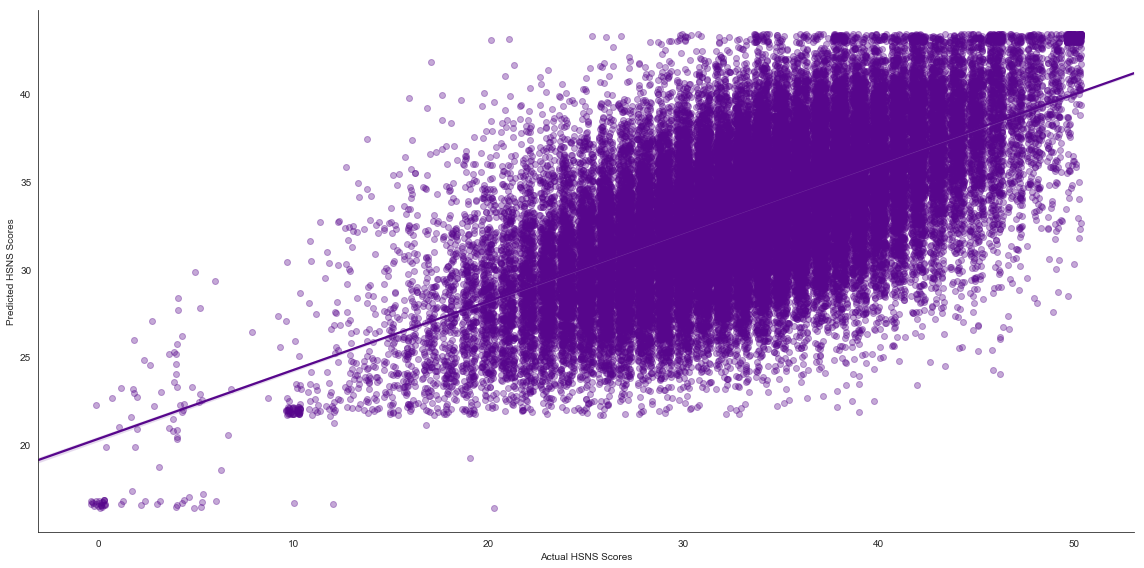

In [48]:
plt.figure(figsize=(15,8))
sns.lmplot(data=netData, x="HSNS_sum", y="PREDICTIONS", aspect=2, 
           x_jitter=0.40, y_jitter=0.25, 
           scatter_kws={"alpha":0.35}, height=8)
plt.xlabel("Actual HSNS Scores")
plt.ylabel("Predicted HSNS Scores")
plt.show()

While the line of best fit accurately passes through the most dense cluster of observations, there is still quite a bit of spread in this representation. This suggests that the model does a good (not great) job of predicting HSNS outcomes based on composite Dark Triad scores.

### Granular Scoring
------------
39% explained variance is robust, but we're interested in improving the model if possible. Rather than using composite scores as regressors, let's use all 12 values as regressors to obtain maximum predictive power. We'll follow the same procedure as we did above, by testing multiple *alpha* values and selecting the value that provides the highest *R-squared*.

In [49]:
target_cols.append("CLUSTER")
nd_wide.drop(target_cols, axis=1, inplace=True)

nd_wide.head()

,DDP1,DDP2,DDP3,DDP4,DDN1,DDN2,DDN3,DDN4,DDM1,DDM2,DDM3,DDM4,HSNS_sum
0,1,1,4,4,2,1,1,1,1,2,2,1,33
1,4,4,2,4,3,2,2,3,4,4,4,3,35
2,2,2,2,4,4,2,4,3,3,4,4,2,41
3,4,2,4,0,5,5,4,1,4,2,3,4,29
4,4,3,4,4,4,2,5,2,4,4,1,5,43


In [50]:
# Segment the data into training and testing components
X = nd_wide.filter(regex="DD")
y = nd_wide.filter(regex="HSNS")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 823)

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1.0]
r2_2 = []
print("Alpha \t\t R^2 \t\t\t\t RMSE")
for a in alphas:

    # Fit model with iterative alpha value + report R^2 and Root Mean Square Error (RMSE)
    temp = ElasticNet(alpha=a).fit(X, y)
    temp_score = temp.score(X, y)
    r2_2.append(temp_score)
    temp_yPred = temp.predict(X)
    mse = mean_squared_error(y, temp_yPred)
    print(str(a) + "\t\t" + str(temp_score) + "\t\t" + str(np.sqrt(mse)))

Alpha 		 R^2 				 RMSE
0.0001		0.41299305156512056		5.272095141699268
0.001		0.4129929955614463		5.272095393192622
0.01		0.4129873455343833		5.272120765470762
0.1		0.4125436607602928		5.274112816115
0.3		0.41028281478356976		5.284251872865953
0.5		0.4063186638050513		5.301982818772349
0.7		0.40101447132907		5.325615195013719
1.0		0.3910472682535271		5.369741875149399


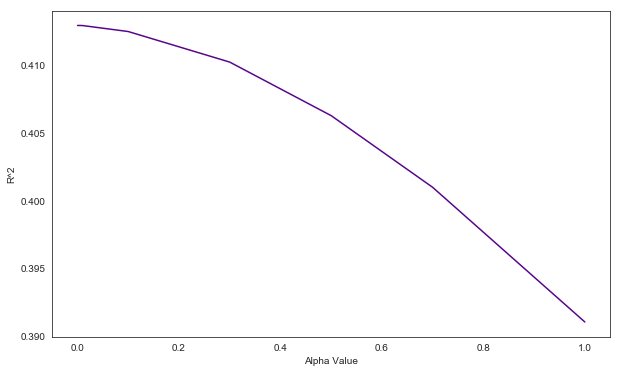

In [51]:
plt.figure(figsize=(10,6))
sns.lineplot(x=alphas, y=r2_2)
plt.xlabel("Alpha Value")
plt.ylabel("R^2")
plt.show()

Similar to the last model, we observe a sharp decline in *R-squared* values as *alpha* increases. We'll use *a*=0.0001 to fit our model in this case as well, as this value provides the most predictive power.

In [52]:
# Train new model
net = ElasticNet(alpha = 0.0001).fit(X_train, y_train)
net_score = net.score(X_test, y_test)
yPred = net.predict(X_test)
mse = mean_squared_error(y_test, yPred)

nd_wide["PREDICTIONS"] = net.predict(X)

print("Alpha \t\t R^2 \t\t\t\t RMSE")
print(str(0.0001) + "\t\t" + str(net_score) + "\t\t" + str(np.sqrt(mse)))

Alpha 		 R^2 				 RMSE
0.0001		0.4127388842717953		5.244787211116169


We observe an *R-squared* value of 0.413, which is a decent increase from the compact model trained earlier. This suggests that including the full array of Dirty Dozen measures - rather than the composite scores - best predicts participants' HSNS scores in this dataset.

In [53]:
net = ElasticNet(alpha = 0.0001).fit(X_train, y_train)
net_coeff = pd.DataFrame() 
net_coeff["Columns"] = X_test.columns 
net_coeff['Coefficient Estimate'] = pd.Series(net.coef_) 
net_coeff

,Columns,Coefficient Estimate
0,DDP1,0.001384
1,DDP2,0.362517
2,DDP3,0.743498
3,DDP4,1.015368
4,DDN1,0.996813
5,DDN2,0.429882
6,DDN3,0.337374
7,DDN4,1.048136
8,DDM1,0.034492
9,DDM2,0.310500


Here, you can see that the item contributing the most to the association with the HSNS composite score is the DDN1 - "I tend to want others to admire me." This item is very similar to many items on the HSNS such as "My feelings are easily hurt by ridicule or the slighting remarks of others," and "I dislike being with a group unless I know that I am appreciated by at least one of those present." This similarity could explain the high degree of association. 

Another item contributing highly to the relationship with the HSNS composite score is DDP3 - "I tend to be callous or insensitive." This item is similar to items on the HSNS such as "I am secretly "put out" or annoyed when other people come to me with their troubles, asking me for my time and sympathy," or "I feel that I have enough on my hands without worrying about other people's troubles." Again, the similarity with items on the HSNS scale explains the high contribution of the DDP3 item to the model. 

**CONCLUSION**

*   We performed a brief exploratory data analysis to assess the structure and collinearity of the features within the dataset. 
*   We split the dataset in 4 meaningfully-different groups using PCA and K-Means Clustering Methods. 
*   We performed a regression analysis using elastic-net to see the predictive nature of the subscales and individual items of the Dirty Dozen scale on the HSNS.
 

**REFERENCES**

Maples, J. L., Lamkin, J., & Miller, J. D. (2014). A test of two brief measures of the dark triad: The dirty dozen and short dark triad. Psychological assessment, 26(1), 326.

Miller, J. D., Dir, A., Gentile, B., Wilson, L., Pryor, L. R., & Campbell, W. K. (2010). Searching for a vulnerable dark triad: Comparing factor 2 psychopathy, vulnerable narcissism, and borderline personality disorder. Journal of personality, 78(5), 1529-1564.

Schoenleber, M., Sadeh, N., & Verona, E. (2011). Parallel syndromes: Two dimensions of narcissism and the facets of psychopathic personality in criminally involved individuals. Personality Disorders: Theory, Research, and Treatment, 2(2), 113.
